## Colour Detection using DL

#### Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile
import random

import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Plot history:

In [2]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Setting up the data:

In [3]:
datagen = ImageDataGenerator(rescale=1./255)   

In [4]:
train_generator = datagen.flow_from_directory(
    'C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

Found 501 images belonging to 10 classes.


In [5]:
test_generator = datagen.flow_from_directory(
    'C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project',
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

Found 501 images belonging to 10 classes.


#### Approach 1: DenseNet Model

In [6]:
# Load DenseNet model
DenseNet_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers except the last 15 layers
for layer in DenseNet_model.layers[:-15]:
    layer.trainable = False

# Build the model
x = DenseNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(units=10, activation='softmax')(x)
model = Model(DenseNet_model.input, output)

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [7]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size

In [9]:
STEP_SIZE_TRAIN

25

In [10]:
STEP_SIZE_VALID

25

In [11]:
history = model.fit_generator(generator=train_generator,
                            steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=test_generator,
                            validation_steps=STEP_SIZE_VALID,
                            epochs=5)

C:\Users\titik\AppData\Local\Temp\ipykernel_8660\499041031.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/5


25/25 [==============================] - 208s 7s/step - loss: 2.4214 - accuracy: 0.2240 - val_loss: 1.7625 - val_accuracy: 0.3920
Epoch 2/5
25/25 [==============================] - 147s 6s/step - loss: 1.6444 - accuracy: 0.4532 - val_loss: 1.1876 - val_accuracy: 0.6060
Epoch 3/5
25/25 [==============================] - 150s 6s/step - loss: 1.2701 - accuracy: 0.5634 - val_loss: 0.7568 - val_accuracy: 0.7640
Epoch 4/5
25/25 [==============================] - 152s 6s/step - loss: 0.9142 - accuracy: 0.6798 - val_loss: 0.4048 - val_accuracy: 0.8900
Epoch 5/5
25/25 [==============================] - 161s 7s/step - loss: 0.8108 - accuracy: 0.7152 - val_loss: 0.3275 - val_accuracy: 0.8920


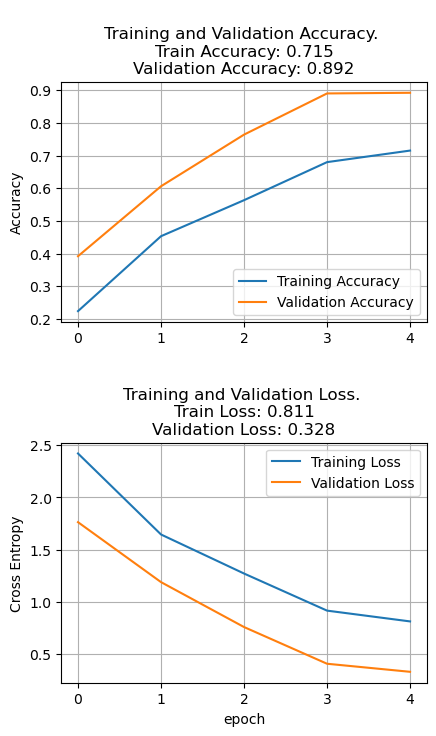

In [12]:
plot_history(history)

#### Approach 2: Inception Model

In [15]:
# Load InceptionV3 model
Inception_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers except the last 15 layers
for layer in Inception_model.layers[:-15]:
    layer.trainable = False

# Build the model
x = Inception_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(units=10, activation='softmax')(x)
model1 = Model(Inception_model.input, output)

model1.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_18

In [18]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model1.fit_generator(generator=train_generator,
                                               steps_per_epoch=STEP_SIZE_TRAIN,
                                               validation_data=test_generator,
                                               validation_steps=STEP_SIZE_VALID,
                                               epochs=10)

C:\Users\titik\AppData\Local\Temp\ipykernel_8660\3741573670.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(generator=train_generator,


Epoch 1/10
25/25 [==============================] - 151s 5s/step - loss: 2.5199 - accuracy: 0.2079 - val_loss: 1.7484 - val_accuracy: 0.4060
Epoch 2/10
25/25 [==============================] - 118s 5s/step - loss: 1.8651 - accuracy: 0.3119 - val_loss: 1.2963 - val_accuracy: 0.5840
Epoch 3/10
25/25 [==============================] - 114s 5s/step - loss: 1.3998 - accuracy: 0.4906 - val_loss: 0.9897 - val_accuracy: 0.5780
Epoch 4/10
25/25 [==============================] - 112s 5s/step - loss: 1.1780 - accuracy: 0.5842 - val_loss: 0.6771 - val_accuracy: 0.7580
Epoch 5/10
25/25 [==============================] - 110s 4s/step - loss: 0.9776 - accuracy: 0.6590 - val_loss: 0.5300 - val_accuracy: 0.8260
Epoch 6/10
25/25 [==============================] - 108s 4s/step - loss: 0.8796 - accuracy: 0.6902 - val_loss: 0.4250 - val_accuracy: 0.8520
Epoch 7/10
25/25 [==============================] - 109s 4s/step - loss: 0.6156 - accuracy: 0.7879 - val_loss: 0.5031 - val_accuracy: 0.7820
Epoch 8/10
25

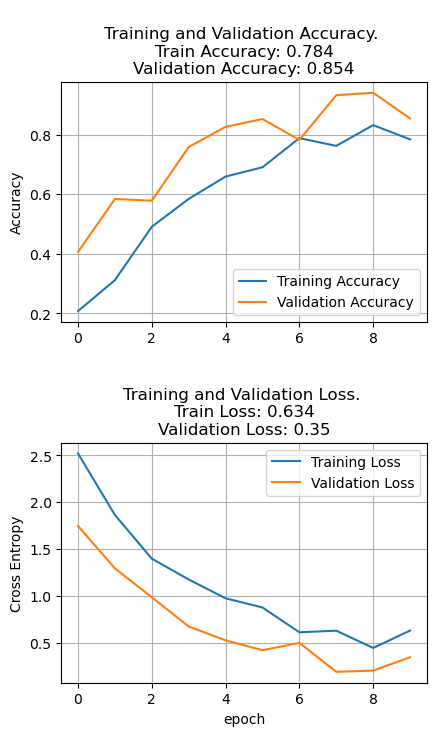

In [19]:
plot_history(history)

In [ ]:
### Approach 3: MobileNet

In [20]:
from keras.applications import MobileNet

# Load the pre-trained MobileNet model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the MobileNet model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the MobileNet model
x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

# Create a new model by specifying the inputs and outputs
model2 = Model(inputs=mobilenet_model.input, outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit_generator(generator=train_generator,
                                               steps_per_epoch=STEP_SIZE_TRAIN,
                                               validation_data=test_generator,
                                               validation_steps=STEP_SIZE_VALID,
                                               epochs=10)


C:\Users\titik\AppData\Local\Temp\ipykernel_8660\469626144.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(generator=train_generator,


Epoch 1/10
25/25 [==============================] - 49s 2s/step - loss: 2.3757 - accuracy: 0.2017 - val_loss: 1.6661 - val_accuracy: 0.4660
Epoch 2/10
25/25 [==============================] - 36s 1s/step - loss: 1.6288 - accuracy: 0.4387 - val_loss: 1.2416 - val_accuracy: 0.5520
Epoch 3/10
25/25 [==============================] - 37s 2s/step - loss: 1.2251 - accuracy: 0.5884 - val_loss: 0.8441 - val_accuracy: 0.7100
Epoch 4/10
25/25 [==============================] - 38s 2s/step - loss: 0.9632 - accuracy: 0.6570 - val_loss: 0.6408 - val_accuracy: 0.7620
Epoch 5/10
25/25 [==============================] - 40s 2s/step - loss: 0.8345 - accuracy: 0.7173 - val_loss: 0.4530 - val_accuracy: 0.8760
Epoch 6/10
25/25 [==============================] - 36s 1s/step - loss: 0.6498 - accuracy: 0.7630 - val_loss: 0.3389 - val_accuracy: 0.9080
Epoch 7/10
25/25 [==============================] - 36s 1s/step - loss: 0.5367 - accuracy: 0.8004 - val_loss: 0.2997 - val_accuracy: 0.9080
Epoch 8/10
25/25 [==

In [25]:
import numpy as np
from keras.preprocessing import image

# Function to load and preprocess a single image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess the image according to the model's requirements
    return img_array

# Function to make predictions on a single image
def predict_image(model, image_path):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    return predictions

# Example usage:
image_path ="C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/violet/voilet13.jpg"
predictions = predict_image(model, image_path)
predicted_class_index = np.argmax(predictions)  # Get the index of the class with the highest probability
print("Predicted class index:", predicted_class_index)


1/1 [==============================] - 0s 355ms/step
Predicted class index: 4


In [26]:
# List of labels for each class
class_labels = ['label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6', 'label_7', 'label_8', 'label_9', 'label_10']

# Example usage:
predicted_class_label = class_labels[predicted_class_index]
print("Predicted class label:", predicted_class_label)


Predicted class label: label_5


In [35]:
# Function to make predictions on a single image and print the predicted class label with its corresponding color
def predict_image_and_print_label_with_color(model2, image_path, class_labels, label_colors):
    predictions = predict_image(model2, image_path)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_color = label_colors.get(predicted_class_label, 'black')  # Get the color for the predicted label, default to black if not found
    print(f"Predicted class label: {predicted_class_label}, Corresponding color: {predicted_class_color}")

# Example usage:
image_path = "C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/black/image4.jpg"# Replace with the path to your violet image
predict_image_and_print_label_with_color(model2, image_path, class_labels, label_colors)


1/1 [==============================] - 3s 3s/step
Predicted class label: label_6, Corresponding color: yellow


In [36]:
# Function to make predictions on a single image and return the predicted class label, corresponding color, and probability
def predict_image_and_return_label_color_probability(model, image_path, class_labels, label_colors):
    predictions = predict_image(model, image_path)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_color = label_colors.get(predicted_class_label, 'black')  # Get the color for the predicted label, default to black if not found
    predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class
    return predicted_class_label, predicted_class_color, predicted_probability

# Example usage:
image_path = "C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/black/image4.jpg"  # Replace with the path to your image
predicted_label, predicted_color, predicted_probability = predict_image_and_return_label_color_probability(model, image_path, class_labels, label_colors)
print(f"Predicted class label: {predicted_label}, Corresponding color: {predicted_color}, Probability: {predicted_probability}")


1/1 [==============================] - 0s 343ms/step
Predicted class label: label_6, Corresponding color: yellow, Probability: 0.9335641860961914


In [60]:
# Dictionary mapping labels to colors
label_colors = {
    'label_1': 'brown',
    'label_2': 'yellow',
    'label_3': 'green',
    'label_4': 'orange',
    'label_5': 'purple',
    'label_6': 'blue',
    'label_7': 'black',
    'label_8': 'red',
    'label_9': 'white',
    'label_10': 'grey'
}



In [64]:
# Function to make predictions on a single image and print the predicted class label with its corresponding color
def predict_image_and_print_label_with_color(model2, image_path, class_labels, label_colors):
    predictions = predict_image(model2, image_path)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_color = label_colors.get(predicted_class_label)  # Get the color for the predicted label, default to black if not found
    print(f"Predicted class label: {predicted_class_label}, Corresponding color: {predicted_class_color}")

# Example usage:
image_path = "C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/yellow/yello9.jpg"# Replace with the path to your violet image
predict_image_and_print_label_with_color(model2, image_path, class_labels, label_colors)


1/1 [==============================] - 0s 166ms/step
Predicted class label: label_2, Corresponding color: yellow


In [ ]:
#"C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/yellow/yello9.jpg"2
#"C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/black/black20.png"7
# "C:/Users/titik/OneDrive/Desktop/6th sem/DLL/Lab/Project/blue/blue2 (2).jpg" 6